In [1]:
import numpy as np
from sklearn.manifold import TSNE
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
import warnings
import networkx as nx
import matplotlib.colors as mcolors
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.metrics.pairwise import cosine_similarity
from scipy import spatial
from networkx.algorithms.community import k_clique_communities
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community import naive_greedy_modularity_communities
from networkx.algorithms.community import label_propagation_communities
import networkx.algorithms.community as nx_comm
from networkx.algorithms.connectivity.edge_kcomponents import bridge_components
import glob 
from scipy.spatial.distance import mahalanobis
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from networkx.readwrite import json_graph
import json
from itertools import islice
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import matplotlib.ticker as tk
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from sklearn.neural_network import MLPClassifier 
import torch 
import torch.nn as nn
import torch.optim as optim
from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler
from sklearn.covariance import GraphicalLassoCV
from networkx.generators.community import gaussian_random_partition_graph
from scipy.stats import ttest_ind
import nibabel as nib 

/data2/MRI_PET_DATA/graph/graph_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#start with formattting data, getting master csv of all patients regional volume 
#create master csv file with all vol for each region for eahc patient
#cols would be 'id','001','002'....
#rows would be id numbers 0173

dir = "/data2/MRI_PET_DATA/graph/ADNI/mri_atlas/roi"
data_dic = {}
patient_data = {}
#iterate through patient folders to extract the values of the .npy files 
for folder in sorted(glob.glob(os.path.join(dir,"wneuromorphometrics_*"))):
    # print(f"processing: {folder}")
    id = folder[-4:]
    volumes = []
    #data dicitonary to store corresponding labels and values 
    for file in sorted(glob.glob(os.path.join(folder, "*.npy"))): #search for all .npy files 
        reg_num = os.path.splitext(os.path.basename(file))[0] #os.path.basename returns filename itself with extension
        #os.path.splittext()[0] splits file basename into a tuple of file name string and the extension (001,.npy) [0] tells it to extract first el of this tuple (001)
        # print(reg_num)
        node_data = np.load(file)
        # print(reg_num, node_data)
        data_dic[reg_num]=node_data
        volumes.append(node_data)

    patient_data[id]=volumes

patient_ids = list(patient_data.keys())

progs_norm = pd.DataFrame.from_dict(patient_data,orient='index')
progs_norm.columns = [str(int(col) + 1) for col in progs_norm.columns]
progs_norm['id'] = patient_ids
progs_norm.to_csv('/data2/MRI_PET_DATA/graph/ADNI/mri_atlas/roi/mega_csv.csv')


In [3]:
#add in progression info and then split dataframes into stable and progressive mci 
prog_info = pd.read_csv("/data2/MRI_PET_DATA/graph/csvs/ADNI_surv_prog.csv")
# all_df = pd.read_csv("/data2/MRI_PET_DATA/graph/ADNI/mri_atlas/roi/hip_weights.csv") #doesn't work if I just read it in as a csv weird 

prog = prog_info[['RID',"PROGRESSES"]]
#add in padded zeros to prog df 
prog['RID']=prog["RID"].astype(str).str.zfill(4)

#filter prog to only include ids we want 
prog = prog[prog["RID"].isin(progs_norm['id'].astype(str))]
print(f"N Progressive MCI={prog['PROGRESSES'].value_counts()[1]}\nN Stable MCI={(545-154)}")  #in entire dataset, only 154 who progress 

#merge all_df df and prog df on index RID and ID
merged = prog.merge(progs_norm,left_on='RID', right_on='id')

merged = merged.drop('id',axis=1) #drop id along col axis 
# print(merged)

N Progressive MCI=154
N Stable MCI=391


/tmp/ipykernel_2342936/4072787975.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prog['RID']=prog["RID"].astype(str).str.zfill(4)


In [16]:
#separate dfs for progressors and stable 
#creat empty dfs 
progs = pd.DataFrame()
stable = pd.DataFrame()

for index,row in merged.iterrows():
    if row['PROGRESSES']==1:
        progs = progs.append(row)
    else:
        stable = stable.append(row)

print(progs)
print(stable)

progs.to_csv("/data2/MRI_PET_DATA/graph/ADNI/mri_atlas/roi/progressors_vol.csv")
stable.to_csv("/data2/MRI_PET_DATA/graph/ADNI/mri_atlas/roi/stable_vol.csv")

      RID  PROGRESSES        1    2    3    4    5    6    7    8  ...    133  \
2    0331         1.0  1459847  119  285  303  147  153  349  354  ...  11197   
3    0376         1.0  1461197  120  284  302  149  138  349  354  ...  11205   
4    0388         1.0  1462081  121  285  302  149  151  348  355  ...  11225   
7    0423         1.0  1461269  122  284  302  150  152  352  351  ...  11261   
8    0429         1.0  1462322  122  285  303  151  154  348  356  ...  11184   
..    ...         ...      ...  ...  ...  ...  ...  ...  ...  ...  ...    ...   
467  4974         1.0  1461260  119  285  303  149  150  349  354  ...  11260   
476  5026         1.0  1459352  119  284  303  151  154  348  353  ...  11251   
484  5285         1.0  1461867  120  286  301  150  150  344  357  ...  11225   
502  6252         1.0  1459859  119  281  303  150  154  350  352  ...  11277   
514  6345         1.0  1461470  122  283  302  149  153  349  356  ...  11281   

       134   135   136   13

In [17]:
#drop row 23 and 25 because they are ventricle and chiasm and have no volume 
# zero_col = df.columns[(df ==0).any()]
# print(zero_col)

#drop 1,2,3,4,23,24,25,26,35,36

progs = progs.drop(['1','2','3','4','23','24','25','26','35','36'], axis =1)
stable = stable.drop(['1','2','3','4','23','24','25','26','35','36'], axis =1)

#drop all the ventricles and region 001 because its the background and not the data we need 
#in this the bacground region 0 and region 1 are both combined in region 1 
progs.to_csv('/data2/MRI_PET_DATA/graph/ADNI/mri_atlas/roi/ADNI_pruned_prog_csv.csv')
stable.to_csv('/data2/MRI_PET_DATA/graph/ADNI/mri_atlas/roi/ADNI_pruned_stable_csv.csv')

In [ ]:
print(progs)
print(stable)

In [18]:
#for the correlation matrix need to only have the values 
progs = progs.drop(["RID","PROGRESSES"], axis =1)
stable = stable.drop(["RID","PROGRESSES"], axis =1)

In [19]:
#convert to float
progs = progs.astype(float)
stable = stable.astype(float)
print(stable)

         5      6      7      8       9      10      11      12       13  \
0    150.0  150.0  350.0  352.0  5258.0  6796.0  1169.0  1277.0  32094.0   
1    149.0  154.0  347.0  354.0  5277.0  6769.0  1169.0  1285.0  32187.0   
5    150.0  153.0  350.0  350.0  5269.0  6813.0  1174.0  1275.0  32176.0   
6    150.0  153.0  347.0  355.0  5258.0  6757.0  1172.0  1280.0  32014.0   
11   146.0  152.0  352.0  360.0  5281.0  6845.0  1174.0  1282.0  32313.0   
..     ...    ...    ...    ...     ...     ...     ...     ...      ...   
539  149.0  154.0  349.0  355.0  5272.0  6797.0  1175.0  1281.0  32135.0   
540  152.0  155.0  350.0  355.0  5279.0  6850.0  1167.0  1274.0  32461.0   
541  148.0  153.0  349.0  347.0  5283.0  6838.0  1173.0  1279.0  32506.0   
542  151.0  152.0  352.0  354.0  5274.0  6808.0  1174.0  1275.0  32399.0   
543  147.0  153.0  351.0  352.0  5303.0  6825.0  1169.0  1282.0  32348.0   

          14  ...      133      134     135     136     137     138     139  \
0    324

In [20]:
#no nan values in df nom
#normalize with z score, negative values are fine it means its an std below mean 
progs_norm = (progs - progs.mean()) / progs.std()
stable_norm = (stable - stable.mean()) / stable.std()
print(progs_norm)
# progs_norm = progs_norm.reset_index(drop=True)
# progs_norm = progs_norm.reset_index(drop=True)


            5         6         7         8         9        10        11  \
2   -1.305644  0.322746  0.227475 -0.121612 -0.013293 -0.469851  0.971008   
3   -0.376918 -5.942324  0.227475 -0.121612 -1.142755 -1.466406 -0.264820   
4   -0.376918 -0.512597 -0.252404  0.268559  0.833803 -1.181676 -0.264820   
7    0.087445 -0.094925  1.667114 -1.292123 -1.001572  0.348748  0.662051   
8    0.551808  0.740417 -0.252404  0.658729 -1.848668 -0.363077  0.353094   
..        ...       ...       ...       ...       ...       ...       ...   
467 -0.376918 -0.930268  0.227475 -0.121612 -1.213346 -1.644362 -0.573778   
476  0.551808  0.740417 -0.252404 -0.511782  0.622029 -0.718989 -1.191692   
484  0.087445 -0.930268 -2.171922  1.048900 -0.789798 -1.003719  0.353094   
502  0.087445  0.740417  0.707355 -0.901952  0.339664  0.455522  0.971008   
514 -0.376918  0.322746  0.227475  0.658729 -0.366250 -1.146084  0.353094   

           12        13        14  ...       133       134       135  \
2  

In [22]:
#gaussian graphical model
#everytime I transpose it flips the data so need to make sure its patients x regions 

#transpose data so that each region is a row instead of a col because that's how the data will be handled 

#NEEDS TO BE 154x132 format for model
progs_norm = progs_norm.T
print(progs_norm)

            5         6         7         8         9        10        11  \
2   -1.305644  0.322746  0.227475 -0.121612 -0.013293 -0.469851  0.971008   
3   -0.376918 -5.942324  0.227475 -0.121612 -1.142755 -1.466406 -0.264820   
4   -0.376918 -0.512597 -0.252404  0.268559  0.833803 -1.181676 -0.264820   
7    0.087445 -0.094925  1.667114 -1.292123 -1.001572  0.348748  0.662051   
8    0.551808  0.740417 -0.252404  0.658729 -1.848668 -0.363077  0.353094   
..        ...       ...       ...       ...       ...       ...       ...   
467 -0.376918 -0.930268  0.227475 -0.121612 -1.213346 -1.644362 -0.573778   
476  0.551808  0.740417 -0.252404 -0.511782  0.622029 -0.718989 -1.191692   
484  0.087445 -0.930268 -2.171922  1.048900 -0.789798 -1.003719  0.353094   
502  0.087445  0.740417  0.707355 -0.901952  0.339664  0.455522  0.971008   
514 -0.376918  0.322746  0.227475  0.658729 -0.366250 -1.146084  0.353094   

           12        13        14  ...       133       134       135  \
2  

In [23]:
#graphical lasso 
#estimates the precision matrix of the data (inverse cov mat which models the partial correlations between vars)
#uses lasso penalty, during training the model iteratively updates the estimated precision matrix using current hyperparamter values until it converges to a set of values that minimize the loss function 
model = GraphicalLassoCV(cv=5) #cv=5 specifies 5-fold cross validation strategy to optimize model hyperparameters 
model.fit(progs_norm)

/data2/MRI_PET_DATA/graph/graph_env/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:272: RuntimeWarning: invalid value encountered in multiply
  precision_[indices != idx, idx] = -precision_[idx, idx] * coefs
/data2/MRI_PET_DATA/graph/graph_env/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:273: RuntimeWarning: invalid value encountered in multiply
  precision_[idx, indices != idx] = -precision_[idx, idx] * coefs
/data2/MRI_PET_DATA/graph/graph_env/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


GraphicalLassoCV(cv=5)

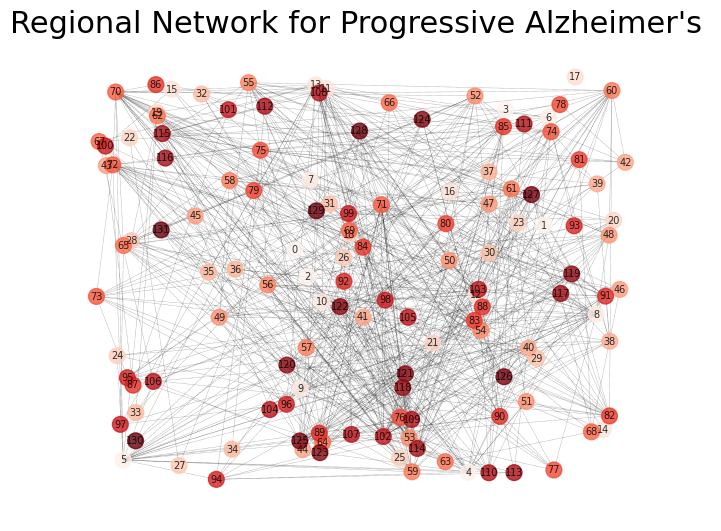

In [24]:
#represents conditional independence structure of data, strength and direction of a relationship between 
#this graph has learned and pruned the weaker connections in the precision matrix
#graph represents the strongest and most important connections between the brain volume 


precision_matrix_p = model.precision_
np.fill_diagonal(precision_matrix_p, 0)
G_prog = nx.Graph(precision_matrix_p)
pos = nx.random_layout(G_prog)
nx.draw(G_prog, pos,with_labels=True, font_size=7, style="dotted", node_color=range(len(precision_matrix_p)),
        cmap=plt.cm.Reds, node_size=150*len(precision_matrix_p)/154, alpha=.8, width=.3)
#size inconsistent and makes me enter 
plt.title("Regional Network for Progressive Alzheimer's ", fontsize=22)
plt.show()


In [25]:
#strongest edges 
#right now its showing edge 0 (background) as being connected strongly with everything because its the background, need to figure out how I would fix this 
#or it could be that the edges start at 0 and I just need to rename them to get it to start at 1 

edges_sorted = sorted(G_prog.edges(data=True),key=lambda x: x[2]['weight'],reverse=True)
edges_sorted_shifted = [(edge[0]+1, edge[1]+1, edge[2]) for edge in edges_sorted]
for edge in edges_sorted_shifted[:10]:
        print(edge)

(14, 68, {'weight': 0.26528718841555665})
(29, 56, {'weight': 0.210762915301263})
(13, 21, {'weight': 0.20689718275857186})
(14, 22, {'weight': 0.1950707724969683})
(14, 20, {'weight': 0.1818976685600706})
(14, 38, {'weight': 0.1690122572011279})
(8, 14, {'weight': 0.15891315965353234})
(13, 67, {'weight': 0.1319381475634363})
(13, 19, {'weight': 0.12871237308841324})
(14, 100, {'weight': 0.12369272413762562})


In [28]:
#stable 
stable_norm = stable_norm.T
print(stable_norm.shape)  #shape needs to be 390 x 140 patients x regions 
#transpose

(390, 132)


In [29]:
#fit for stable norm df 
stab_model = GraphicalLassoCV(cv=5)
stab_model.fit(stable_norm)

/data2/MRI_PET_DATA/graph/graph_env/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


GraphicalLassoCV(cv=5)

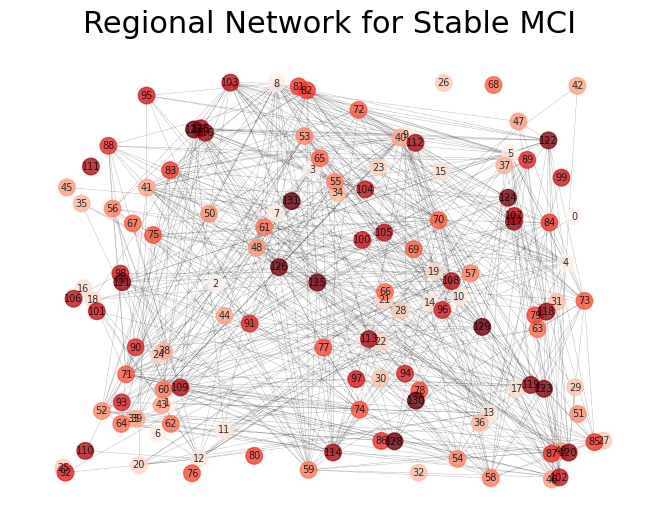

In [30]:
#stable graph 
precision_matrix_s = stab_model.precision_
np.fill_diagonal(precision_matrix_s, 0)
G_stab = nx.Graph(precision_matrix_s)
pos = nx.random_layout(G_stab)
nx.draw(G_stab, pos,with_labels=True, font_size=7, style="dotted", node_color=range(len(precision_matrix_s)),
        cmap=plt.cm.Reds, node_size=150*len(precision_matrix_s)/140, alpha=.8, width=.3)
plt.title("Regional Network for Stable MCI", fontsize=22)
plt.show()

In [35]:
import networkx as nx
import pandas as pd

# Construct the graph
G_stab = nx.Graph(precision_matrix_s)

# Calculate metrics for each patient
clust_coeffs = []
path_efficiencies = []
modularities = []

for i in range(stable_norm.shape[0]):
    # Get the indices of the nodes for the i-th patient
    node_indices = range(i * 142, (i + 1) * 142)
    
    # Calculate the clustering coefficient for the i-th patient
    cc = nx.average_clustering(G_stab.subgraph(node_indices))
    clust_coeffs.append(cc)
    
    # Calculate the global path efficiency for the i-th patient
    gpe = nx.global_efficiency(G_stab.subgraph(node_indices))
    path_efficiencies.append(gpe)
    
    # Calculate the modularity for the i-th patient
    communities = list(nx.algorithms.community.label_propagation.label_propagation_communities(G_stab.subgraph(node_indices)))
    labels = [label for comm in communities for label in comm]
    mod = nx.algorithms.community.quality.modularity(G_stab.subgraph(node_indices), labels)
    modularities.append(mod)
    
# Add the results to a pandas DataFrame
results = pd.DataFrame({
    'Clustering Coefficient': clust_coeffs,
    'Path Efficiency': path_efficiencies,
    'Modularity': modularities
})


TypeError: 'int' object is not iterable

In [34]:
#see if any of the edges are significantly different 

edge_weights_prog = nx.to_numpy_array(G_prog)
edge_weights_stab = nx.to_numpy_array(G_stab)

# run t-test on all edge weights
t_stat, p_val = ttest_ind(edge_weights_prog.flatten(), edge_weights_stab.flatten())

print(t_stat) #-1.085
print(p_val) #.2778 not sig difference between edges 


# # print significant edges
# sig_edges_prog = np.where(p_val < 0.05, edge_weights_prog.flatten(), np.nan)
# sig_edges_stab = np.where(p_val < 0.05, edge_weights_stab.flatten(), np.nan)



-1.0857734137936335
0.2775867626099492


In [ ]:
#compare graph metrics 

#modularity 
mod_p = nx.algorithms.community.modularity(G_prog, nx.algorithms.community.greedy_modularity_communities(G_prog))
print("Prog Modularity:", mod_p)
mod_s = nx.algorithms.community.modularity(G_stab, nx.algorithms.community.greedy_modularity_communities(G_stab))
print("Stable Modularity:", mod_s)

#global path effiency 
ge_p = nx.global_efficiency(G_prog)
print("\nProg Global efficiency:", ge_p)
ge_s = nx.global_efficiency(G_stab)
print("Stable Global efficiency:", ge_s)

#clustering coefficient 
cl_p = nx.average_clustering(G_prog)
print(f"\nProg Clustering Coeff:",cl_p)
cl_s = nx.average_clustering(G_stab)
print(f"Stable Clustering Coeff",cl_s)

In [ ]:
#plot metrics 

# Define the data for the three bar plots
m_scores = [mod_p, mod_s]
g_scores = [ge_p, ge_s]
c_scores = [cl_p, cl_s]

labels = ["Progressive MCI", "Stable MCI"]

# Create a figure with three subplots, one for each bar plot
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

# first subplot
axs[0].bar(labels, m_scores)
axs[0].set_ylabel("Modularity Score")
axs[0].set_title("Comparison of Modularity Scores")

# second subplot
axs[1].bar(labels, g_scores)
axs[1].set_ylabel("Global Path Efficiency Score")
axs[1].set_title("Comparison of Efficiency Scores")

#third subplot
axs[2].bar(labels, c_scores)
axs[2].set_ylabel("Clustering Coefficient Score")
axs[2].set_title("Clustering Coefficient Scores")

# Adjust the spacing between subplots and display the figure
plt.subplots_adjust(wspace=0.5)
plt.show()


In [ ]:
#sig test 
from scipy.stats import mannwhitneyu

# Calculate test statistics and p-values for each metric
mod_u, mod_pval = mannwhitneyu(mod_p, mod_s)
ge_u, ge_pval = mannwhitneyu(ge_p, ge_s)
cl_u, cl_pval = mannwhitneyu(cl_p, cl_s)

# Print results
print("Modularity U-statistic:", mod_u)
print("Modularity p-value:", mod_pval)
print("Global efficiency U-statistic:", ge_u)
print("Global efficiency p-value:", ge_pval)
print("Clustering coefficient U-statistic:", cl_u)
print("Clustering coefficient p-value:", cl_pval)


In [ ]:
#try to construct a graph for each patient, save edge weights and then calc metrics for each group 
import networkx as nx
import numpy as np
from sklearn.covariance import GraphicalLassoCV

# Initialize model
model = GraphicalLassoCV(cv=5)

# Loop over all patients
for i in range(progs_norm.shape[0]):

    # Fit graphical lasso model
    model.fit(progs_norm[i, :].reshape(-1, 142))
    precision_matrix_p = model.precision_
    np.fill_diagonal(precision_matrix_p, 0)

    # Construct graph
    G_prog = nx.Graph(precision_matrix_p)

    # Save edge weights
    edge_weights = nx.to_numpy_array(G_prog)

    # Calculate modularity
    modularity = nx.algorithms.community.modularity_max.greedy_modularity_communities(G_prog)

    # Calculate clustering coefficient
    clustering_coefficient = nx.average_clustering(G_prog)

    # Calculate global path efficiency
    global_path_efficiency = nx.algorithms.distance_measures.global_efficiency(G_prog)

    # Visualize graph
    pos = nx.random_layout(G_prog)
    nx.draw(G_prog, pos,with_labels=True, font_size=7, style="dotted", node_color=range(len(precision_matrix_p)),
            cmap=plt.cm.Reds, node_size=150*len(precision_matrix_p)/154, alpha=.8, width=.3)
    plt.title(f"Regional Network for Patient {i+1}", fontsize=22)
    plt.show()


In [81]:
#no matter what I try the values for indvs are all the same 
threshold = 0.1
precision_matrix_s = stab_model.precision_
np.fill_diagonal(precision_matrix_s, 0)

# Create graph object from precision matrix
G_stab = nx.from_numpy_matrix(precision_matrix_s)

# Compute modularity for each individual
modularities = []
for i in range(progs_norm.shape[0]):
    volumes = progs_norm.iloc[i, :].values
    individual_precision_matrix = np.abs(stab_model.precision_) > threshold
    np.fill_diagonal(individual_precision_matrix, 0)
    individual_graph = nx.from_numpy_matrix(individual_precision_matrix)
    partition = nx.algorithms.community.greedy_modularity_communities(individual_graph)
    modularity = nx.algorithms.community.modularity(individual_graph, partition)
    modularities.append(modularity)
    print(modularity)

# Compute global efficiency for each individual
global_efficiencies = []
for i in range(progs_norm.shape[0]):
    volumes = progs_norm.iloc[i, :].values
    individual_precision_matrix = np.abs(stab_model.precision_) > threshold
    np.fill_diagonal(individual_precision_matrix, 0)
    individual_graph = nx.from_numpy_matrix(individual_precision_matrix)
    global_efficiency = nx.global_efficiency(individual_graph)
    global_efficiencies.append(global_efficiency)

# Compute clustering coefficient for each individual
clustering_coefficients = []
for i in range(progs_norm.shape[0]):
    volumes = progs_norm.iloc[i, :].values
    individual_precision_matrix = np.abs(stab_model.precision_) > threshold
    np.fill_diagonal(individual_precision_matrix, 0)
    individual_graph = nx.from_numpy_matrix(individual_precision_matrix)
    clustering_coefficient = nx.average_clustering(individual_graph)
    clustering_coefficients.append(clustering_coefficient)


0.6099145540569169
0.6099145540569169
0.6099145540569169
0.6099145540569169
0.6099145540569169
0.6099145540569169
0.6099145540569169
0.6099145540569169
0.6099145540569169
0.6099145540569169
0.6099145540569169
0.6099145540569169
0.6099145540569169
0.6099145540569169
0.6099145540569169
0.6099145540569169
0.6099145540569169
0.6099145540569169
0.6099145540569169
0.6099145540569169
0.6099145540569169
0.6099145540569169
0.6099145540569169
0.6099145540569169
0.6099145540569169
0.6099145540569169
0.6099145540569169
0.6099145540569169
0.6099145540569169
0.6099145540569169
0.6099145540569169
0.6099145540569169
0.6099145540569169
0.6099145540569169
0.6099145540569169
0.6099145540569169
0.6099145540569169
0.6099145540569169
0.6099145540569169
0.6099145540569169
0.6099145540569169
0.6099145540569169
0.6099145540569169
0.6099145540569169
0.6099145540569169
0.6099145540569169
0.6099145540569169
0.6099145540569169
0.6099145540569169
0.6099145540569169
0.6099145540569169
0.6099145540569169
0.6099145540

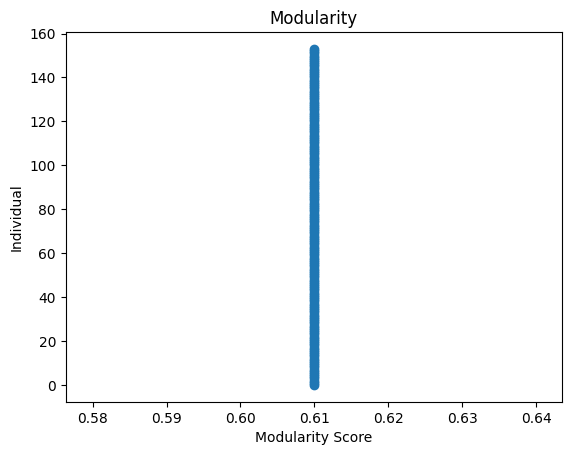

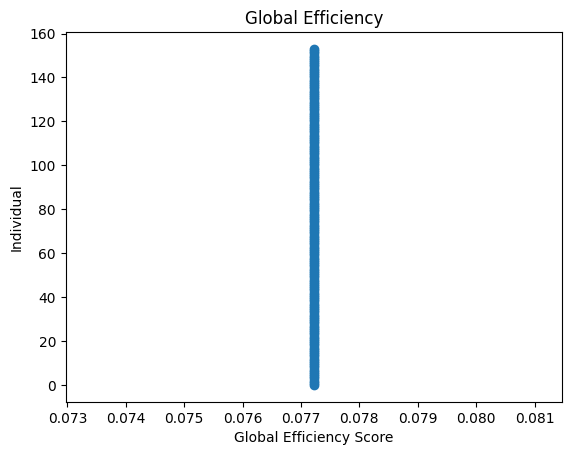

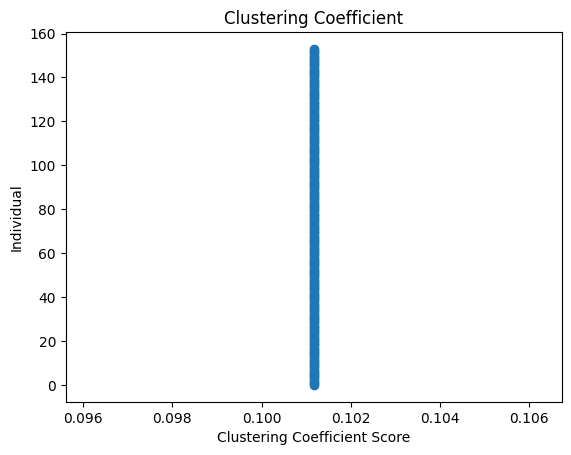

In [80]:
import matplotlib.pyplot as plt

# Plot modularity
plt.scatter(modularities, range(len(modularities)))
plt.title('Modularity')
plt.xlabel('Modularity Score')
plt.ylabel('Individual')

# Plot global efficiency
plt.figure()
plt.scatter(global_efficiencies, range(len(global_efficiencies)))
plt.title('Global Efficiency')
plt.xlabel('Global Efficiency Score')
plt.ylabel('Individual')

# Plot clustering coefficient
plt.figure()
plt.scatter(clustering_coefficients, range(len(clustering_coefficients)))
plt.title('Clustering Coefficient')
plt.xlabel('Clustering Coefficient Score')
plt.ylabel('Individual')

plt.show()


Text(0.5, 0, 'Clustering Coefficient')

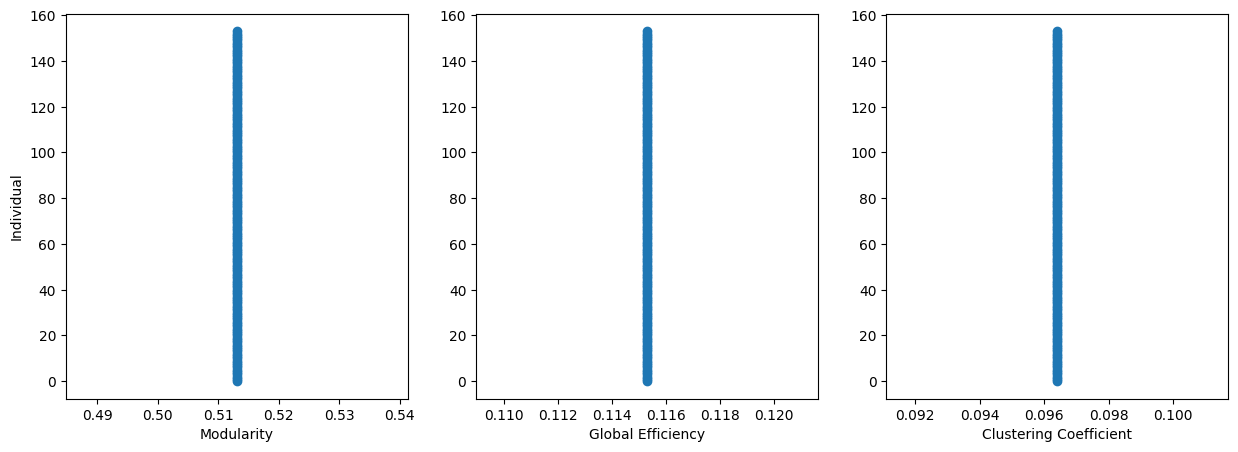

In [78]:
# Train model and compute precision matrix


# Compute graph metrics for each individual
threshold = 0.1
modularities = []
global_efficiencies = []
clustering_coefficients = []

for i in range(progs_norm.shape[0]):
    volumes = progs_norm.iloc[i, :].values
    individual_adjacency = np.abs(precision_matrix_p) > threshold
    individual_adjacency = individual_adjacency.astype(int) # convert boolean to integer
    individual_graph = nx.from_numpy_matrix(individual_adjacency)
    
    partition = nx.algorithms.community.greedy_modularity_communities(individual_graph)
    modularity = nx.algorithms.community.modularity(individual_graph, partition)
    modularities.append(modularity)
    
    global_efficiency = nx.global_efficiency(individual_graph)
    global_efficiencies.append(global_efficiency)
    
    clustering_coefficient = nx.average_clustering(individual_graph)
    clustering_coefficients.append(clustering_coefficient)

metrics_df = pd.DataFrame(metrics, columns=['Modularity', 'Global Efficiency', 'Clustering Coefficient'])

# Scatter plot the data points for each metric
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].scatter(metrics_df['Modularity'], range(progs_norm.shape[0]))
axs[0].set_xlabel('Modularity')
axs[0].set_ylabel('Individual')
axs[1].scatter(metrics_df['Global Efficiency'], range(progs_norm.shape[0]))
axs[1].set_xlabel('Global Efficiency')
axs[2].scatter(metrics_df['Clustering Coefficient'], range(progs_norm.shape[0]))
axs[2].set_xlabel('Clustering Coefficient')

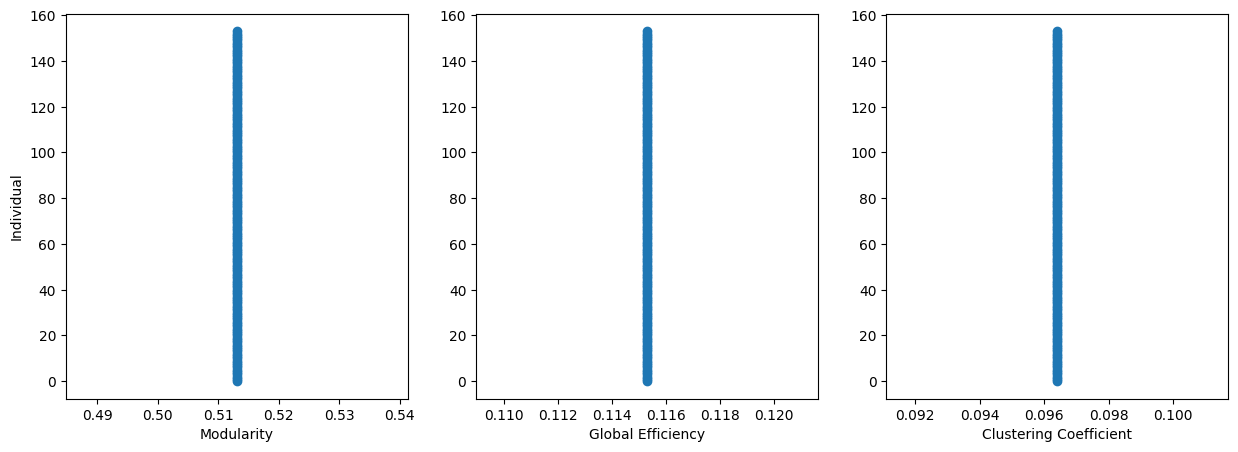

In [76]:
import pandas as pd

# Compute graph metrics for each individual
threshold = 0.1
adjacency = np.abs(precision_matrix_p) > threshold
adjacency = adjacency.astype(int)  # convert boolean to integer
graph = nx.from_numpy_matrix(adjacency)

metrics = []
for i in range(progs_norm.shape[0]):
    volumes = progs_norm.iloc[i, :].values
    individual_adjacency = np.abs(precision_matrix_p) > threshold
    individual_adjacency = individual_adjacency.astype(int)  # convert boolean to integer
    individual_graph = nx.from_numpy_matrix(individual_adjacency)
    
    # Compute modularity
    partition = nx.algorithms.community.greedy_modularity_communities(individual_graph)
    modularity = nx.algorithms.community.modularity(individual_graph, partition)
    
    # Compute global efficiency
    global_efficiency = nx.global_efficiency(individual_graph)
    
    # Compute clustering coefficient
    clustering_coefficient = nx.average_clustering(individual_graph)
    
    # Append to list of metrics for all individuals
    metrics.append([modularity, global_efficiency, clustering_coefficient])

# Store metrics in pandas DataFrame
metrics_df = pd.DataFrame(metrics, columns=['Modularity', 'Global Efficiency', 'Clustering Coefficient'])

# Scatter plot the data points for each metric
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].scatter(metrics_df['Modularity'], range(progs_norm.shape[0]))
axs[0].set_xlabel('Modularity')
axs[0].set_ylabel('Individual')
axs[1].scatter(metrics_df['Global Efficiency'], range(progs_norm.shape[0]))
axs[1].set_xlabel('Global Efficiency')
axs[2].scatter(metrics_df['Clustering Coefficient'], range(progs_norm.shape[0]))
axs[2].set_xlabel('Clustering Coefficient')

plt.show()


In [ ]:
#graph metrics for each individual in each group 

# Assuming you have a 500 row x 142 col dataframe with the volumes of each brain region for each patient

# Fit graphical Lasso model
# model = GraphicalLassoCV(cv=5)
# model.fit(progs)

# Get precision matrix


# Convert precision matrix to adjacency matrix
threshold = 0.1  # set threshold to control sparsity of graph
adjacency = np.abs(precision_matrix_p) > threshold

# Create graph object from adjacency matrix
graph = nx.from_numpy_matrix(adjacency)

# Compute modularity for each individual
modularities = []
for i in range(progs_norm.shape[0]):
    volumes = progs_norm.iloc[i, :].values
    individual_adjacency = np.abs(precision_matrix_p) > threshold  # use the same threshold for all individuals
    individual_graph = nx.from_numpy_matrix(individual_adjacency)
    partition = nx.algorithms.community.greedy_modularity_communities(individual_graph)
    modularity = nx.algorithms.community.modularity(individual_graph, partition)
    modularities.append(modularity)
    
# Compute global efficiency for each individual
global_efficiencies = []
for i in range(progs_norm.shape[0]):
    volumes = progs_norm.iloc[i, :].values
    individual_adjacency = np.abs(precision_matrix_p) > threshold  # use the same threshold for all individuals
    individual_graph = nx.from_numpy_matrix(individual_adjacency)
    global_efficiency = nx.global_efficiency(individual_graph)
    global_efficiencies.append(global_efficiency)
    
# Compute clustering coefficient for each individual
clustering_coefficients = []
for i in range(progs_norm.shape[0]):
    volumes = progs_norm.iloc[i, :].values
    individual_adjacency = np.abs(precision_matrix_p) > threshold  # use the same threshold for all individuals
    individual_graph = nx.from_numpy_matrix(individual_adjacency)
    clustering_coefficient = nx.average_clustering(individual_graph)
    clustering_coefficients.append(clustering_coefficient)




In [ ]:
print(modularities)

In [ ]:
#scatter plot of the values for each indivdial 
met = pd.DataFrame({'Modularity': modularities, 'global effiency' : global_efficiencies, 'clustering coeff': clustering_coefficient})
print(met)



plt.scatter(met.index,met['Modularity'])
plt.xlabel('individuals')
plt.ylabel('Mod score')
plt.show()